# Anális de consumo Cobify

## Importamos librerías

In [33]:
import numpy as np 
import pandas as pd
import pymysql

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from pandas.plotting import scatter_matrix


from sklearn.datasets import make_circles, load_boston
from sklearn.model_selection import train_test_split as tts

from sklearn.linear_model import LinearRegression as LinReg

## Observamos el estado de los datos

In [2]:
df = pd.read_csv("measurements.csv")

In [3]:
df

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
383,16,"3,7",39,"24,5",18,NaN,SP98,0,0,0,NaN,NaN
384,"16,1","4,3",38,25,31,AC,SP98,1,0,0,NaN,NaN
385,16,"3,8",45,25,19,NaN,SP98,0,0,0,NaN,NaN
386,"15,4","4,6",42,25,31,AC,SP98,1,0,0,NaN,NaN


### En un primer vistazo, observamos que los separadores decimales son comas y no puntos. Además Tenemos NaN y columnas de diferentes tipos. Algunas tienen espacios en el títilo de las columnas (Dificulta el manejo)

In [4]:
df.columns

Index(['distance', 'consume', 'speed', 'temp_inside', 'temp_outside',
       'specials', 'gas_type', 'AC', 'rain', 'sun', 'refill liters',
       'refill gas'],
      dtype='object')

In [5]:
df.dtypes

distance         object
consume          object
speed             int64
temp_inside      object
temp_outside      int64
specials         object
gas_type         object
AC                int64
rain              int64
sun               int64
refill liters    object
refill gas       object
dtype: object

### Cambiamos el nombre de las columnas

In [6]:
df = df.rename(columns={k:v for k,v in [('refill liters','refill_liters'), ('refill gas', 'refill_gas')]})

In [7]:
df

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill_liters,refill_gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
383,16,"3,7",39,"24,5",18,NaN,SP98,0,0,0,NaN,NaN
384,"16,1","4,3",38,25,31,AC,SP98,1,0,0,NaN,NaN
385,16,"3,8",45,25,19,NaN,SP98,0,0,0,NaN,NaN
386,"15,4","4,6",42,25,31,AC,SP98,1,0,0,NaN,NaN


### Observamos los valores nulos

In [8]:
null_cols = df.isnull().sum()
null_cols[null_cols > 0]

temp_inside       12
specials         295
refill_liters    375
refill_gas       375
dtype: int64

### Quitamos nulos 

In [9]:
df.specials=df.specials.fillna('None') 

### Para poder quitar los de temp_inside debemos limpir antes. Aprovechamos y limpiamos todas las columnas

In [10]:
df['temp_inside'] = df['temp_inside'].apply(lambda x: str(x).replace(',', '.'))

In [11]:
df['specials'] = df['specials'].apply(lambda x: x.replace('ac', 'AC').replace('Sun', 'sun').replace('half ', '').replace('sun AC', 'AC sun'))

In [12]:
set(df['specials'])

{'AC',
 'AC rain',
 'AC snow',
 'AC sun',
 'None',
 'rain',
 'rain sun',
 'snow',
 'sun'}

In [13]:
df['distance'] = df['distance'].apply(lambda x: str(x).replace(',', '.'))

In [14]:
df['consume'] = df['consume'].apply(lambda x: str(x).replace(',', '.'))

In [15]:
df['refill_liters'] = df['refill_liters'].apply(lambda x: str(x).replace(',', '.'))

### Cambiamos el tipo de dato a decimal para las columnas numéricas

In [16]:
df = df.astype({"distance": float, "consume": float, "temp_inside": float, "refill_liters": float})

### Aora sí, podemos rellenar nulos por la media

In [17]:

df.temp_inside=df.temp_inside.fillna(df.temp_inside.mean())

In [18]:
df.temp_inside.value_counts()

21.500000    133
22.000000    102
22.500000     59
20.000000     25
21.000000     13
23.000000     13
21.929521     12
25.000000     12
24.500000      7
20.500000      4
24.000000      3
25.500000      2
23.500000      2
19.000000      1
Name: temp_inside, dtype: int64

### Para hacer dummies en Specials, crearemos colunmnas dummy manualmente para AC y rain

In [19]:
df.specials.value_counts()

None        295
rain         32
sun          27
AC           14
AC rain      10
AC sun        5
snow          3
AC snow       1
rain sun      1
Name: specials, dtype: int64

In [20]:
df['specials_AC'] = 0

In [21]:
for i in range(len(df)):
    if 'AC' in df.specials[i]:
        df['specials_AC'][i] = 1

In [22]:
df['specials_rain'] = 0

In [23]:
for i in range(len(df)):
    if 'rain' in df.specials[i]:
        df['specials_rain'][i] = 1

In [24]:
set(df.gas_type)

{'E10', 'SP98'}

### Eliminamos las palabras rain y AC de la columna Specials

In [25]:
df['specials'] = df['specials'].apply(lambda x: x.replace('AC', '').replace('rain', ''))

In [26]:
df

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill_liters,refill_gas,specials_AC,specials_rain
0,28.0,5.0,26,21.5,12,None,E10,0,0,0,45.0,E10,0,0
1,12.0,4.2,30,21.5,13,None,E10,0,0,0,NaN,NaN,0,0
2,11.2,5.5,38,21.5,15,None,E10,0,0,0,NaN,NaN,0,0
3,12.9,3.9,36,21.5,14,None,E10,0,0,0,NaN,NaN,0,0
4,18.5,4.5,46,21.5,15,None,E10,0,0,0,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,16.0,3.7,39,24.5,18,None,SP98,0,0,0,NaN,NaN,0,0
384,16.1,4.3,38,25.0,31,,SP98,1,0,0,NaN,NaN,1,0
385,16.0,3.8,45,25.0,19,None,SP98,0,0,0,NaN,NaN,0,0
386,15.4,4.6,42,25.0,31,,SP98,1,0,0,NaN,NaN,1,0


In [27]:
df_d = pd.get_dummies(df, columns =['gas_type','specials'], drop_first=True)
df_d

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill_liters,refill_gas,specials_AC,specials_rain,gas_type_SP98,specials_,specials_ snow,specials_ sun,specials_None,specials_snow,specials_sun
0,28.0,5.0,26,21.5,12,0,0,0,45.0,E10,0,0,0,0,0,0,1,0,0
1,12.0,4.2,30,21.5,13,0,0,0,NaN,NaN,0,0,0,0,0,0,1,0,0
2,11.2,5.5,38,21.5,15,0,0,0,NaN,NaN,0,0,0,0,0,0,1,0,0
3,12.9,3.9,36,21.5,14,0,0,0,NaN,NaN,0,0,0,0,0,0,1,0,0
4,18.5,4.5,46,21.5,15,0,0,0,NaN,NaN,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,16.0,3.7,39,24.5,18,0,0,0,NaN,NaN,0,0,1,0,0,0,1,0,0
384,16.1,4.3,38,25.0,31,1,0,0,NaN,NaN,1,0,1,0,0,0,0,0,0
385,16.0,3.8,45,25.0,19,0,0,0,NaN,NaN,0,0,1,0,0,0,1,0,0
386,15.4,4.6,42,25.0,31,1,0,0,NaN,NaN,1,0,1,0,0,0,0,0,0


### Eliminamos la columna sobrante de los dummies y refill_liters	refill_gas para poder modelar

In [43]:
df_d = df_d.drop(columns=['refill_liters', 'refill_gas', 'AC', 'rain','sun'])
#Y las columnas que no habia visto que ya estaban (AC, rain y sun)

In [31]:
#la columna index_ no se me borra por algún motivo. pero por falta de tiempo proseguimos

## Creamos un modelo lineal para poder interpretar la influencia de cada variable para el consumo

### No observamos correlaciones claras:

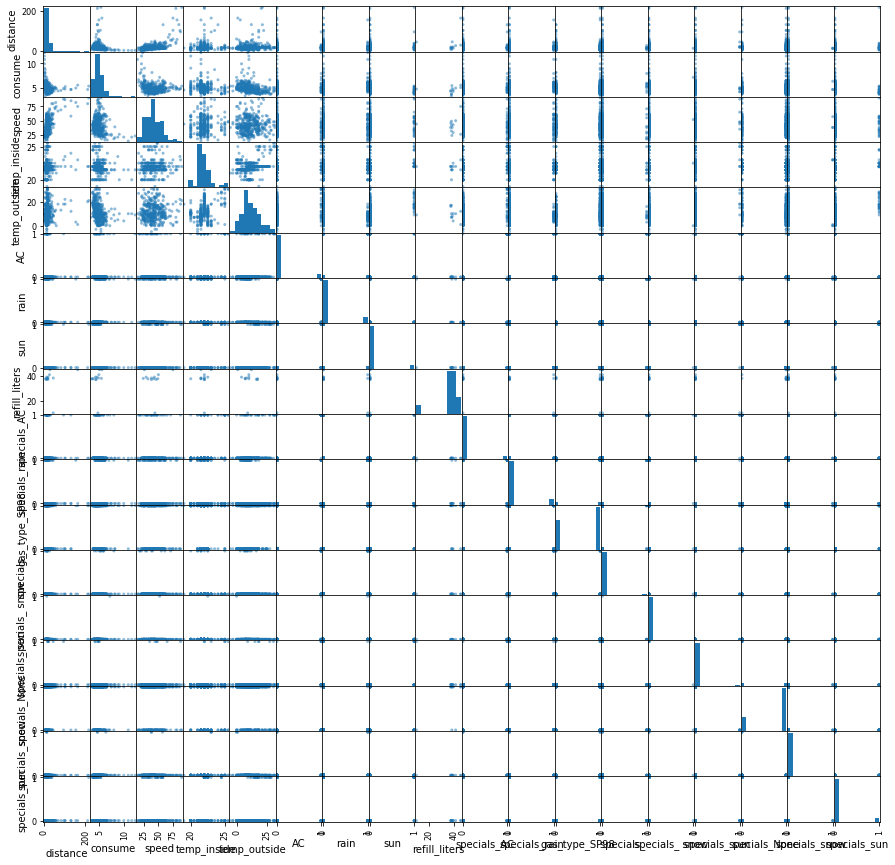

In [34]:
scatter_matrix(df_d, figsize=(15, 15));

In [44]:
df_d.dtypes

distance          float64
consume           float64
speed               int64
temp_inside       float64
temp_outside        int64
specials_AC         int64
specials_rain       int64
gas_type_SP98       uint8
specials_           uint8
specials_ snow      uint8
specials_ sun       uint8
specials_None       uint8
specials_snow       uint8
specials_sun        uint8
dtype: object

In [45]:
X=df_d.drop(['consume'], axis=1)

y=df_d.consume

In [46]:
linreg=LinReg()

linreg.fit(X, y)

LinearRegression()

In [47]:
linreg.coef_

array([ 1.77889463e-03, -1.88565767e-02, -6.21736344e-02, -4.01732117e-02,
        1.11223893e-01,  3.41085181e-01, -5.74414131e-04, -1.61500927e-01,
        1.78251771e+00,  1.11437605e-01, -1.30523921e-01, -1.38810032e-01,
       -3.44476048e-01])

In [ ]:
'''falta ver si cada variable es significativa, eliminarlas del modelo o modificarlas (log, cuadrados). 
Y cuando tengamos un modelo que explique el consumo, podemos comentar como afecta en media cada variable 
al consumo.
'''